In [1]:
import numpy as np                  # import numpy to make numerical computations.
import nltk                         # import NLTK to handle simple NL tasks like tokenization.
nltk.download("punkt")
import math
from nltk.util import ngrams
from collections import Counter     # import a counter.
import sacrebleu                    # import sacrebleu in order compute the BLEU score.
import matplotlib.pyplot as plt     # import pyplot in order to make some illustrations.

[nltk_data] Downloading package punkt to /Users/kangchieh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Bleu score
$$BLEU = BP\times\Bigl(\prod_{i=1}^{4}precision_i\Bigr)^{(1/4)}$$

$$BP = min\Bigl(1, e^{(1-({ref}/{cand}))}\Bigr)$$

$$precision_i = \frac {\sum_{snt \in{cand}}\sum_{i\in{snt}}min\Bigl(m^{i}_{cand}, m^{i}_{ref}\Bigr)}{w^{i}_{t}}$$

## Example

### BP

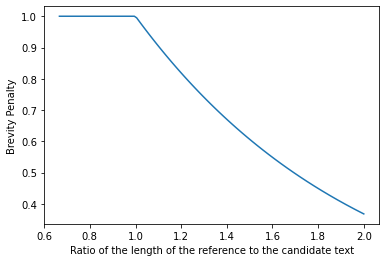

In [2]:
ref_length = np.ones(100)
can_length = np.linspace(1.5, 0.5, 100)
x = ref_length / can_length
y = 1 - x
y = np.exp(y)
y = np.minimum(np.ones(y.shape), y)

# Code for in order to make the plot
fig, ax = plt.subplots(1)
lines = ax.plot(x, y)
ax.set(
    xlabel="Ratio of the length of the reference to the candidate text",
    ylabel="Brevity Penalty",
)
plt.show()

### N-Gram Precision

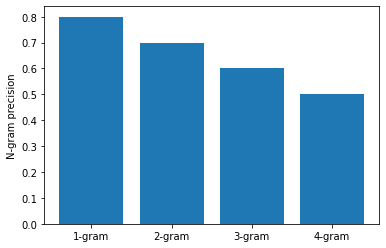

In [3]:
# Mocked dataset showing the precision for different n-grams
data = {"1-gram": 0.8, "2-gram": 0.7, "3-gram": 0.6, "4-gram": 0.5}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1)
bars = ax.bar(names, values)
ax.set(ylabel="N-gram precision")

plt.show()

## Example Calculations of the BLEU score

In [4]:
reference = "The NASA Opportunity rover is battling a massive dust storm on planet Mars."
candidate_1 = "The Opportunity rover is combating a big sandstorm on planet Mars."
candidate_2 = "A NASA rover is fighting a massive storm on planet Mars."

tokenized_ref = nltk.word_tokenize(reference.lower())
tokenized_cand_1 = nltk.word_tokenize(candidate_1.lower())
tokenized_cand_2 = nltk.word_tokenize(candidate_2.lower())

print(f"{reference} -> {tokenized_ref}")
print("\n")
print(f"{candidate_1} -> {tokenized_cand_1}")
print("\n")
print(f"{candidate_2} -> {tokenized_cand_2}")

The NASA Opportunity rover is battling a massive dust storm on planet Mars. -> ['the', 'nasa', 'opportunity', 'rover', 'is', 'battling', 'a', 'massive', 'dust', 'storm', 'on', 'planet', 'mars', '.']


The Opportunity rover is combating a big sandstorm on planet Mars. -> ['the', 'opportunity', 'rover', 'is', 'combating', 'a', 'big', 'sandstorm', 'on', 'planet', 'mars', '.']


A NASA rover is fighting a massive storm on planet Mars. -> ['a', 'nasa', 'rover', 'is', 'fighting', 'a', 'massive', 'storm', 'on', 'planet', 'mars', '.']


### BP

In [5]:
def brevity_penalty(candidate, reference):
    ref_length = len(reference)
    can_length = len(candidate)

    # Brevity Penalty
    if ref_length < can_length: # if reference length is less than candidate length
        BP = 1 # set BP = 1
    else:
        penalty = 1 - (ref_length / can_length) # else set BP=exp(1-(ref_length/can_length))
        BP = np.exp(penalty)

    return BP

In [12]:
cand_n_gram = Counter(ngrams(["i", "like", "you", "you", "like", "me"], 2))
cand_n_gram

Counter({('i', 'like'): 1,
         ('like', 'you'): 1,
         ('you', 'you'): 1,
         ('you', 'like'): 1,
         ('like', 'me'): 1})

### Clipped precision

In [6]:
def clipped_precision(candidate, reference):
    """
    Clipped precision function given a original and a machine translated sentences
    """

    clipped_precision_score = []
    
    for i in range(1, 5):
        ref_n_gram = Counter(ngrams(reference,i))        
        cand_n_gram = Counter(ngrams(candidate,i))                

        c = sum(cand_n_gram.values())        
        
        for j in cand_n_gram: # for every n-gram up to 4 in candidate text
            if j in ref_n_gram: # check if it is in the reference n-gram
                if cand_n_gram[j] > ref_n_gram[j]: # if the count of the candidate n-gram is bigger
                                                   # than the corresponding count in the reference n-gram,
                    cand_n_gram[j] = ref_n_gram[j] # then set the count of the candidate n-gram to be equal
                                                   # to the reference n-gram
            else:
                cand_n_gram[j] = 0 # else set the candidate n-gram equal to zero

                        
        clipped_precision_score.append(sum(cand_n_gram.values())/c)
        
    weights =[0.25]*4

    s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))

    s = math.exp(math.fsum(s))
    return s


### Compute BLEU score

In [7]:
def bleu_score(candidate, reference):
    BP = brevity_penalty(candidate, reference)
    precision = clipped_precision(candidate, reference)
    return BP * precision

### Test with examples

In [8]:
print(
    "Results reference versus candidate 1 our own code BLEU: ",
    round(bleu_score(tokenized_cand_1, tokenized_ref) * 100, 1),
)
print(
    "Results reference versus candidate 2 our own code BLEU: ",
    round(bleu_score(tokenized_cand_2, tokenized_ref) * 100, 1),
)

Results reference versus candidate 1 our own code BLEU:  27.6
Results reference versus candidate 2 our own code BLEU:  35.3


### Compare the results from Sacrebleu Library

In [9]:
print(
    "Results reference versus candidate 1 sacrebleu library sentence BLEU: ",
    round(sacrebleu.sentence_bleu(candidate_1, [reference]).score, 1), 
)

print(
    "Results reference versus candidate 2 sacrebleu library sentence BLEU: ",
    round(sacrebleu.sentence_bleu(candidate_2, [reference]).score, 1), 
)

Results reference versus candidate 1 sacrebleu library sentence BLEU:  27.6
Results reference versus candidate 2 sacrebleu library sentence BLEU:  35.3


# BLEU computation on a corpus

In [13]:
wmt19_src = open("./data/data/wmt19_src.txt", "r")
wmt19_src_1 = wmt19_src.read()
wmt19_src.close()

wmt19_ref = open("./data/data/wmt19_ref.txt", "r")
wmt19_ref_1 = wmt19_ref.read()
wmt19_ref.close()

wmt19_can = open("./data/data/wmt19_can.txt", "r")
wmt19_can_1 = wmt19_can.read()
wmt19_can.close()

tokenized_corpus_src = nltk.word_tokenize(wmt19_src_1.lower())
tokenized_corpus_ref = nltk.word_tokenize(wmt19_ref_1.lower())
tokenized_corpus_cand = nltk.word_tokenize(wmt19_can_1.lower())

In [14]:
print("English source text:")
print("\n")
print(f"{wmt19_src_1[0:170]} -> {tokenized_corpus_src[0:30]}")
print("\n")
print("German reference translation:")
print("\n")
print(f"{wmt19_ref_1[0:219]} -> {tokenized_corpus_ref[0:35]}")
print("\n")
print("German machine translation:")
print("\n")
print(f"{wmt19_can_1[0:199]} -> {tokenized_corpus_cand[0:29]}")

English source text:


﻿Welsh AMs worried about 'looking like muppets'
There is consternation among some AMs at a suggestion their title should change to MWPs (Member of the Welsh Parliament).
 -> ['\ufeffwelsh', 'ams', 'worried', 'about', "'looking", 'like', "muppets'", 'there', 'is', 'consternation', 'among', 'some', 'ams', 'at', 'a', 'suggestion', 'their', 'title', 'should', 'change', 'to', 'mwps', '(', 'member', 'of', 'the', 'welsh', 'parliament', ')', '.']


German reference translation:


﻿Walisische Ageordnete sorgen sich "wie Dödel auszusehen"
Es herrscht Bestürzung unter einigen Mitgliedern der Versammlung über einen Vorschlag, der ihren Titel zu MWPs (Mitglied der walisischen Parlament) ändern soll.
 -> ['\ufeffwalisische', 'ageordnete', 'sorgen', 'sich', '``', 'wie', 'dödel', 'auszusehen', "''", 'es', 'herrscht', 'bestürzung', 'unter', 'einigen', 'mitgliedern', 'der', 'versammlung', 'über', 'einen', 'vorschlag', ',', 'der', 'ihren', 'titel', 'zu', 'mwps', '(', 'mitglied', 'd

In [15]:
print(
    "Results reference versus candidate 1 our own BLEU implementation: ",
    round(bleu_score(tokenized_corpus_cand, tokenized_corpus_ref) * 100, 1),
)

Results reference versus candidate 1 our own BLEU implementation:  43.6


In [16]:
print(
    "Results reference versus candidate 1 sacrebleu library BLEU: ",
    round(sacrebleu.sentence_bleu(wmt19_can_1, [wmt19_ref_1]).score, 1),
)

Results reference versus candidate 1 sacrebleu library BLEU:  43.2
